# *Лабораторная работа №1*

## Построение бинарного классификатора (Теоретическая часть)

Мы продолжаем работу над датасетом с данными о проданных подержанных автомобилях в Германии в 2016 году (см. [ссылку](https://colab.research.google.com/drive/1ReG_EYTl61ni1JOBNNPEeWwdRT3iofy_?usp=sharing)). В рамках текущей лабораторной необходимо построить модель бинарного классификатора, который бы позволил определить была ли машина в ремонте или нет. 


Подключим все необходимые для дальнейшей работы библиотеки.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from keras import models
from keras import layers

import warnings
warnings.filterwarnings("ignore")

Загрузим базу данных, которая была получена нами в ходе предыдущей работы, т.е. в ней уже проведена определенная работа по очистке данных (подробнее см. лаб1). 

In [12]:
%%capture
!wget https://www.dropbox.com/s/s1sqfsi6x7hbs28/autos_mod.csv

Записываем ее в датафрейм и проверим столбцы на наличие пустых значений.

In [13]:
df = pd.read_csv('autos_mod.csv', encoding='iso-8859-1')
df.isnull().any()

FileNotFoundError: [Errno 2] No such file or directory: 'autos_mod.csv'

Удалим столбец, который возник в процессе переписывания набора данных, так как никакой полезной информации он не несет.

In [4]:
del df["Unnamed: 0"]

Воспользуемся самым ленивым способом восстановления данных и очистим все столбцы от пустых значений, чтобы работать с исключительно неповрежденными записями.

In [5]:
df = df.drop(df[pd.isnull(df['vehicleType'])].index)
df = df.drop(df[pd.isnull(df['gearbox'])].index)
df = df.drop(df[pd.isnull(df['model'])].index)
df = df.drop(df[pd.isnull(df['fuelType'])].index)
df = df.drop(df[pd.isnull(df['notRepairedDamage'])].index)

Проверим, что у нас не осталось записей с пустыми значениями.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250919 entries, 2 to 329656
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               250919 non-null  int64 
 1   vehicleType         250919 non-null  object
 2   yearOfRegistration  250919 non-null  int64 
 3   gearbox             250919 non-null  object
 4   powerPS             250919 non-null  int64 
 5   model               250919 non-null  object
 6   kilometer           250919 non-null  int64 
 7   fuelType            250919 non-null  object
 8   brand               250919 non-null  object
 9   notRepairedDamage   250919 non-null  object
dtypes: int64(4), object(6)
memory usage: 21.1+ MB


В нашем наборе данных достаточно большое количество полей типа object. Для того, чтобы с ними можно было работать, необходимо провести факторизацию, но сначала рассмотрим эти значения.

In [7]:
df['vehicleType'].unique()

array(['kleinwagen', 'limousine', 'cabrio', 'kombi', 'suv', 'bus',
       'coupe', 'andere'], dtype=object)

In [8]:
df['gearbox'].unique()

array(['manuell', 'automatik'], dtype=object)

In [9]:
df['model'].unique()

array(['golf', 'fabia', '3er', '2_reihe', 'andere', '3_reihe', 'passat',
       'navara', 'twingo', 'c_max', 'a_klasse', 'scirocco', '5er',
       'arosa', 'civic', 'transporter', 'punto', 'e_klasse', 'one',
       'clio', '1er', 'b_klasse', 'fortwo', 'a8', 'jetta', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'scenic', 'a1', 'focus', 'tt', 'astra', 'a6', 'jazz',
       'polo', 'slk', '7er', 'combo', '80', '147', 'glk', 'meriva',
       'z_reihe', 'ibiza', 'mustang', 'eos', 'a4', 'touran', 'getz',
       'insignia', 'megane', 'a3', 'lupo', 'r19', 'colt', 'corsa',
       'vectra', 'berlingo', 'm_klasse', 'tiguan', '6_reihe', 'c4',
       'panda', 'up', 'i_reihe', 'ceed', 'kangoo', '5_reihe', 'yeti',
       'octavia', 'zafira', 'mii', 'rx_reihe', 'mondeo', '6er', 'fox',
       'matiz', 'beetle', 'rio', 'touareg', 'logan', 'omega', 'cuore',
       's_max', 'modus', 'a2', 'x_reihe', 'a5', 'galaxy', 'c3', 'viano',
       's_klasse', 'sharan',

In [10]:
df['fuelType'].unique()

array(['benzin', 'diesel', 'lpg', 'andere', 'hybrid', 'cng', 'elektro'],
      dtype=object)

In [11]:
df['notRepairedDamage'].unique()

array(['nein', 'ja'], dtype=object)

Для поля, которое нас интересует больше всего проверим соотношение количества записей, относящихся к разным классам.

In [12]:
df['notRepairedDamage'].value_counts()

nein    225322
ja       25597
Name: notRepairedDamage, dtype: int64

Отношение 1 к 10 не является хорошим, так как обеспечивает перевес объектов одного класса. Данный момент можно попытаться обойти, уравновесив выборки по принадлежности к классам. В рамках данной методички продолжим обучение на необработанной выборке.

Проведем факторизацию и проверим результат ее исполнения.

In [13]:
names = ['vehicleType', 'gearbox', 'model', 'fuelType', 'brand', 'notRepairedDamage']
for name in names:
    df[name] = pd.factorize(df[name])[0]
df.head()

,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
2,1500,0,2001,0,75,0,150000,0,0,0
3,3600,0,2008,0,69,1,90000,1,1,0
4,650,1,1995,0,102,2,150000,0,2,1
5,2200,2,2004,0,109,3,150000,0,3,0
6,0,1,1980,0,50,4,40000,0,0,0


Как мы можем видеть, в результате удаления части значений из базы данных, произошло нарушение следования индексов. В рамках нашей задачи данный аспект некритичен, но все же произведемсброс индексации.

In [14]:
df = df.reset_index(drop=True)
df.head()

,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
0,1500,0,2001,0,75,0,150000,0,0,0
1,3600,0,2008,0,69,1,90000,1,1,0
2,650,1,1995,0,102,2,150000,0,2,1
3,2200,2,2004,0,109,3,150000,0,3,0
4,0,1,1980,0,50,4,40000,0,0,0


Проверим, как стали выглядеть исследуемые классы после факторизации.

In [15]:
df['notRepairedDamage'].value_counts()

0    225322
1     25597
Name: notRepairedDamage, dtype: int64

Разобьем весь наш набора данных на тренировочный и тестовый наборы данных.


*Вопрос на подумать:* Какое разбиение можно считать удачным при работе с подобным набором данных?

In [16]:
values = df['notRepairedDamage']
points = df.drop(['notRepairedDamage'], axis=1)
train_points, test_points, train_values, test_values = train_test_split(points, values, test_size = 0.2)

Создадим достаточно простенькую модель из 10 решающих деревьев и оценим точность ее работы.

In [17]:
rf_model = ensemble.RandomForestClassifier(n_estimators=10)
rf_model.fit(train_points, train_values)
test_predict_rf = rf_model.predict(test_points)
print(accuracy_score(test_values, test_predict_rf))

0.9006456241032998


С одной стороны, точность работы классификатора, близкая к 90% - хороший показатель. С другой стороны, не будем забывать о том, что распределение классов в нашем датасете неравномерное. Поэтому проведем сравнение с константным классификатором.

In [18]:
print(accuracy_score(test_values, np.zeros_like(test_values)))

0.8991112705244699


Классификатор, который абсолютно все объекты относит к одному и тому же классу, работает с сопоставимой точностью. В этом и состоит основная сложность работы с несбалансированными наборами данных. Попробуем увеличить количество деревьев в модели.

In [19]:
rf_model = ensemble.RandomForestClassifier(n_estimators=100)
rf_model.fit(train_points, train_values)
test_predict_rf = rf_model.predict(test_points)
print(accuracy_score(test_values, test_predict_rf))

0.9047305914235613


Увеличение количества деревьев привело к улучшению результата, но от идеала он по-прежнему далек. В качестве альтернативы попробуем использовать аппарат искусственных нейронных сетей.

In [20]:
model = models.Sequential()

model.add(layers.Dense(9, activation = "relu"))

model.add(layers.Dense(15, activation = "relu"))

model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)
results = model.fit(
 train_points, train_values,
 epochs= 5,
 batch_size = 1000,
 validation_data = (test_points, test_values)
)
print("Test-Accuracy:", np.max(results.history["accuracy"]))

Epoch 1/5
201/201 [==============================] - 3s 7ms/step - loss: 1199.6790 - accuracy: 0.8105 - val_loss: 34.6244 - val_accuracy: 0.8834
Epoch 2/5
201/201 [==============================] - 1s 5ms/step - loss: 43.7859 - accuracy: 0.8604 - val_loss: 28.6842 - val_accuracy: 0.8965
Epoch 3/5
201/201 [==============================] - 1s 3ms/step - loss: 51.2750 - accuracy: 0.8298 - val_loss: 29.5730 - val_accuracy: 0.8969
Epoch 4/5
201/201 [==============================] - 1s 4ms/step - loss: 68.5027 - accuracy: 0.8316 - val_loss: 27.8245 - val_accuracy: 0.5908
Epoch 5/5
201/201 [==============================] - 1s 3ms/step - loss: 45.8866 - accuracy: 0.8287 - val_loss: 49.3122 - val_accuracy: 0.8978
Test-Accuracy: 0.8603830933570862


Данная модель демонстрирует крайнюю неустойчивость, так как при каждом запуске значение точности сильно разнится. Если мы уменьшим количество записей, обрабатываемых между корректировкой весов, то сможем получить более стабильный результат.

In [21]:
model = models.Sequential()

model.add(layers.Dense(9, activation = "relu"))

model.add(layers.Dense(15, activation = "relu"))

model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)
results = model.fit(
 train_points, train_values,
 epochs= 5,
 batch_size = 100,
 validation_data = (test_points, test_values)
)
print("Test-Accuracy:", np.max(results.history["accuracy"]))

Epoch 1/5
2008/2008 [==============================] - 7s 3ms/step - loss: 78.6335 - accuracy: 0.8209 - val_loss: 15.3930 - val_accuracy: 0.8974
Epoch 2/5
2008/2008 [==============================] - 6s 3ms/step - loss: 22.8365 - accuracy: 0.8261 - val_loss: 80.9555 - val_accuracy: 0.8905
Epoch 3/5
2008/2008 [==============================] - 5s 3ms/step - loss: 24.9798 - accuracy: 0.8299 - val_loss: 21.7417 - val_accuracy: 0.8987
Epoch 4/5
2008/2008 [==============================] - 6s 3ms/step - loss: 61.8216 - accuracy: 0.8319 - val_loss: 2.6010 - val_accuracy: 0.8071
Epoch 5/5
2008/2008 [==============================] - 6s 3ms/step - loss: 27.2665 - accuracy: 0.8293 - val_loss: 21.4359 - val_accuracy: 0.4935
Test-Accuracy: 0.8319077491760254


Для окончательного закрепления результата увеличим количество эпох обучения до 10, чтобы кривая обучения успевала сходиться.

In [22]:
model = models.Sequential()

model.add(layers.Dense(9, activation = "relu"))

model.add(layers.Dense(15, activation = "relu"))

model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)
results = model.fit(
 train_points, train_values,
 epochs= 10,
 batch_size = 100,
 validation_data = (test_points, test_values)
)
print("Test-Accuracy:", np.max(results.history["accuracy"]))

Epoch 1/10
2008/2008 [==============================] - 7s 3ms/step - loss: 293.0300 - accuracy: 0.8199 - val_loss: 11.5345 - val_accuracy: 0.8982
Epoch 2/10
2008/2008 [==============================] - 5s 2ms/step - loss: 139.2712 - accuracy: 0.8427 - val_loss: 9.9574 - val_accuracy: 0.8982
Epoch 3/10
2008/2008 [==============================] - 7s 3ms/step - loss: 57.7626 - accuracy: 0.8450 - val_loss: 6.3594 - val_accuracy: 0.8351
Epoch 4/10
2008/2008 [==============================] - 7s 3ms/step - loss: 103.9363 - accuracy: 0.8645 - val_loss: 0.9218 - val_accuracy: 0.8976
Epoch 5/10
2008/2008 [==============================] - 7s 3ms/step - loss: 92.0451 - accuracy: 0.8849 - val_loss: 2.1148 - val_accuracy: 0.8991
Epoch 6/10
2008/2008 [==============================] - 5s 3ms/step - loss: 114.1660 - accuracy: 0.8929 - val_loss: 1.8319 - val_accuracy: 0.8991
Epoch 7/10
2008/2008 [==============================] - 6s 3ms/step - loss: 58.1913 - accuracy: 0.8953 - val_loss: 1.7535 - v

Попробуем ввести дополнительный скрытый слой в сеть, чтобы упростить задачу классификации выходному слою нейронов.

In [23]:
model = models.Sequential()

model.add(layers.Dense(10, activation = "relu"))

model.add(layers.Dense(15, activation = "relu"))

model.add(layers.Dense(8, activation = "relu"))

model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)
results = model.fit(
 train_points, train_values,
 epochs= 10,
 batch_size = 100,
 validation_data = (test_points, test_values)
)
print("Test-Accuracy:", np.max(results.history["accuracy"]))

Epoch 1/10
2008/2008 [==============================] - 7s 3ms/step - loss: 58.1373 - accuracy: 0.8384 - val_loss: 5.8423 - val_accuracy: 0.8991
Epoch 2/10
2008/2008 [==============================] - 6s 3ms/step - loss: 22.5302 - accuracy: 0.8298 - val_loss: 8.4191 - val_accuracy: 0.8952
Epoch 3/10
2008/2008 [==============================] - 5s 3ms/step - loss: 6.7645 - accuracy: 0.8275 - val_loss: 4.5269 - val_accuracy: 0.8987
Epoch 4/10
2008/2008 [==============================] - 6s 3ms/step - loss: 8.3319 - accuracy: 0.8290 - val_loss: 3.1005 - val_accuracy: 0.8961
Epoch 5/10
2008/2008 [==============================] - 6s 3ms/step - loss: 3.8712 - accuracy: 0.8285 - val_loss: 1.1052 - val_accuracy: 0.8971
Epoch 6/10
2008/2008 [==============================] - 7s 3ms/step - loss: 2.5726 - accuracy: 0.8324 - val_loss: 1.1846 - val_accuracy: 0.8979
Epoch 7/10
2008/2008 [==============================] - 5s 3ms/step - loss: 2.0931 - accuracy: 0.8349 - val_loss: 0.5491 - val_accurac

Благодаря уменьшению количества нейронов на предпоследнем слое, нейронная сеть смогла с большей точностью определять ключевые компоненты и учитывать их при вынесении вердикта о принадлежности объекта тому или иному классу.

Ради интереса, попробуем ввести дополнительную метрику при обучении и оценим, насколька она меняет результат к лучшему.

In [24]:
from keras import backend
 
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [25]:
model = models.Sequential()

model.add(layers.Dense(10, activation = "relu"))

model.add(layers.Dense(15, activation = "relu"))

model.add(layers.Dense(8, activation = "relu"))

model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy", rmse]
)
results = model.fit(
 train_points, train_values,
 epochs= 10,
 batch_size = 100,
 validation_data = (test_points, test_values)
)
print("Test-Accuracy:", np.max(results.history["accuracy"]))

Epoch 1/10
2008/2008 [==============================] - 9s 4ms/step - loss: 41.9335 - accuracy: 0.8851 - rmse: 0.3136 - val_loss: 1.1752 - val_accuracy: 0.8979 - val_rmse: 0.2457
Epoch 2/10
2008/2008 [==============================] - 6s 3ms/step - loss: 15.5848 - accuracy: 0.8923 - rmse: 0.2150 - val_loss: 0.3275 - val_accuracy: 0.8991 - val_rmse: 0.1886
Epoch 3/10
2008/2008 [==============================] - 7s 3ms/step - loss: 0.3302 - accuracy: 0.8977 - rmse: 0.1854 - val_loss: 0.3271 - val_accuracy: 0.8991 - val_rmse: 0.1830
Epoch 4/10
2008/2008 [==============================] - 7s 3ms/step - loss: 0.3301 - accuracy: 0.8977 - rmse: 0.1838 - val_loss: 0.3270 - val_accuracy: 0.8991 - val_rmse: 0.1824
Epoch 5/10
2008/2008 [==============================] - 6s 3ms/step - loss: 0.3301 - accuracy: 0.8977 - rmse: 0.1838 - val_loss: 0.3270 - val_accuracy: 0.8991 - val_rmse: 0.1814
Epoch 6/10
2008/2008 [==============================] - 6s 3ms/step - loss: 0.3301 - accuracy: 0.8977 - rmse

Введение дополнительных метрик в процесс обучения может положительно сказаться на результате, но необходимо четко понимать назначение той или иной метрики. Для бинарного классификатора наиболее подходящей будет f-мера.

Кроме работы непосредственно с моделями и их составляющими, можно попробовать преобразовать данные для их лучшей интерпретируемости системой. В данном случае, поле года выпуска автомобиля имеет плохую форму распределения.

<Axes: >

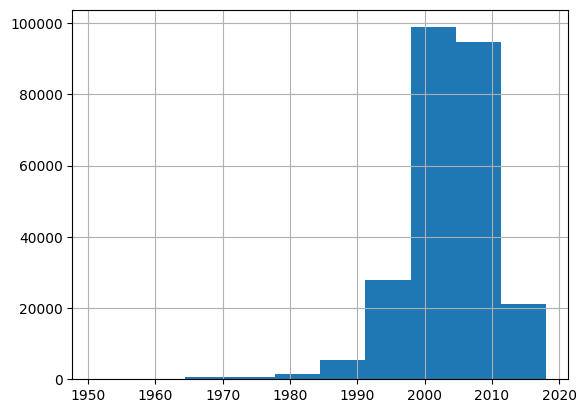

In [26]:
df['yearOfRegistration'].hist()

Введем вместо него поле с возрастом.

In [27]:
df['age'] = 2020 - df['yearOfRegistration']
del df['yearOfRegistration']
df.head()

,price,vehicleType,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage,age
0,1500,0,0,75,0,150000,0,0,0,19
1,3600,0,0,69,1,90000,1,1,0,12
2,650,1,0,102,2,150000,0,2,1,25
3,2200,2,0,109,3,150000,0,3,0,16
4,0,1,0,50,4,40000,0,0,0,40


In [28]:
values = df['notRepairedDamage']
points = df.drop(['notRepairedDamage'], axis=1)
train_points, test_points, train_values, test_values = train_test_split(points, values, test_size = 0.2)

In [29]:
rf_model = ensemble.RandomForestClassifier(n_estimators=100)
rf_model.fit(train_points, train_values)
test_predict_rf = rf_model.predict(test_points)
print(accuracy_score(test_values, test_predict_rf))

0.9055675115574685


In [30]:
model = models.Sequential()

model.add(layers.Dense(9, activation = "relu"))

model.add(layers.Dense(15, activation = "relu"))

model.add(layers.Dense(8, activation = "relu"))

model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)
results = model.fit(
 train_points, train_values,
 epochs= 10,
 batch_size = 100,
 validation_data = (test_points, test_values)
)
print("Test-Accuracy:", np.max(results.history["accuracy"]))

Epoch 1/10
2008/2008 [==============================] - 7s 3ms/step - loss: 38.8207 - accuracy: 0.8319 - val_loss: 2.0345 - val_accuracy: 0.8977
Epoch 2/10
2008/2008 [==============================] - 7s 3ms/step - loss: 28.6734 - accuracy: 0.8223 - val_loss: 4.2469 - val_accuracy: 0.8975
Epoch 3/10
2008/2008 [==============================] - 7s 3ms/step - loss: 4.2433 - accuracy: 0.8770 - val_loss: 0.6054 - val_accuracy: 0.8977
Epoch 4/10
2008/2008 [==============================] - 7s 3ms/step - loss: 9.6802 - accuracy: 0.8971 - val_loss: 0.3853 - val_accuracy: 0.8977
Epoch 5/10
2008/2008 [==============================] - 5s 3ms/step - loss: 8.0021 - accuracy: 0.8979 - val_loss: 0.3302 - val_accuracy: 0.8977
Epoch 6/10
2008/2008 [==============================] - 6s 3ms/step - loss: 0.3293 - accuracy: 0.8981 - val_loss: 0.3302 - val_accuracy: 0.8977
Epoch 7/10
2008/2008 [==============================] - 6s 3ms/step - loss: 0.3293 - accuracy: 0.8981 - val_loss: 0.3302 - val_accurac

Для обеих моделей мы получили увеличение точности. Попробуем пойти еще немного дальше, объединив два поля в одно. Такой подход называют уменьшением размерности, так как он позволяет работать с входным вектором меньшего размера.

In [31]:
df['intence'] = df['kilometer']/df['age']
del df['kilometer']
del df['age']

In [32]:
values = df['notRepairedDamage']
points = df.drop(['notRepairedDamage'], axis=1)
train_points, test_points, train_values, test_values = train_test_split(points, values, test_size = 0.2)

In [33]:
rf_model = ensemble.RandomForestClassifier(n_estimators=100)
rf_model.fit(train_points, train_values)
test_predict_rf = rf_model.predict(test_points)
print(accuracy_score(test_values, test_predict_rf))

0.903913597959509


In [34]:
model = models.Sequential()

model.add(layers.Dense(8, activation = "relu"))

model.add(layers.Dense(15, activation = "relu"))

model.add(layers.Dense(8, activation = "relu"))

model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)
results = model.fit(
 train_points, train_values,
 epochs= 10,
 batch_size = 100,
 validation_data = (test_points, test_values)
)
print("Test-Accuracy:", np.max(results.history["accuracy"]))

Epoch 1/10
2008/2008 [==============================] - 7s 3ms/step - loss: 1.7194 - accuracy: 0.8630 - val_loss: 3.5102 - val_accuracy: 0.8987
Epoch 2/10
2008/2008 [==============================] - 6s 3ms/step - loss: 0.6978 - accuracy: 0.8731 - val_loss: 18.5619 - val_accuracy: 0.8989
Epoch 3/10
2008/2008 [==============================] - 6s 3ms/step - loss: 0.6315 - accuracy: 0.8806 - val_loss: 2.1765 - val_accuracy: 0.8806
Epoch 4/10
2008/2008 [==============================] - 7s 4ms/step - loss: 0.5435 - accuracy: 0.8867 - val_loss: 5.9678 - val_accuracy: 0.8309
Epoch 5/10
2008/2008 [==============================] - 5s 3ms/step - loss: 0.5095 - accuracy: 0.8861 - val_loss: 20.1704 - val_accuracy: 0.8982
Epoch 6/10
2008/2008 [==============================] - 6s 3ms/step - loss: 0.3159 - accuracy: 0.8941 - val_loss: 0.4225 - val_accuracy: 0.8988
Epoch 7/10
2008/2008 [==============================] - 6s 3ms/step - loss: 0.2972 - accuracy: 0.8965 - val_loss: 0.3708 - val_accurac

Умменьшение размерности нашего входного вектора не привело к улучшению общей картины. Не всегда одни и те же шаги приводят к одному и тому же результату. Из-за специфики датасета действенность метода может очень сильно варьироваться.

## Построение бинарного классификатора (Практическая часть)

###Задание базового уровня

Произвести очистку датасета от поврежденных значений и шума. На основе очищенного датасета построить бинарный классификатор для определения пола человека, пользующегося смартфоном.

Данное задание основано на данном датасете с kaggle (https://www.kaggle.com/pwang001/user-package-information-of-mobile-operators).

###Задание повышенного уровня

Выполнить задание базового уровня. Точность полученного решения должна быть выше отметки **85%**.

**Ограничения по реализации:**

*Случайный лес*: не более 100 деревьев.

*Нейронные сети*: не более трех скрытых слоев. 

**Даже при использовании собственных метрик в процессе обучения. Итоговая оценка должна производиться по метрике *Accuracy*.**

## Загрузка датасета в память

На данный момент датасте разделен на 4 части. Возможны два сценария работы с ним:

1. Объединить два фрагмента с меткой train в тренировочныйц набор, а фрагменты с меткой test - в тестовый.

2. Объединить все четыре фрагмента в единый датасет, затем провести разделение на тренировочный и тестовый наборы с помощью функции train_test_split с **нефиксированным сидом рандома**.

In [35]:
%%capture
!wget https://www.dropbox.com/s/5b6o99k5ko6cr1r/train_1.csv
!wget https://www.dropbox.com/s/br8m56fomdxs7lw/train_2.csv
!wget https://www.dropbox.com/s/xmw5shslewwfi0n/test_1.csv
!wget https://www.dropbox.com/s/uxxc48au1zclpu2/test_2.csv